In [1]:
'''
Author: Ibsa Jalata
Date: April 10, 2023
Description: A supervised model that reconstruct 
high quality MR images from undersampled input MR images
'''
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset 
import PIL.Image as Image
import os
import glob
import random
import matplotlib.image
from matplotlib import cm
import numpy as np
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import torch.optim as optim 
import csv 
import pandas as pd 
import seaborn as sns

In [2]:
#metrics for measurement
def compute_psnr(ref, x):
    """Compute peak to signal to noise ratio."""
    max_val = np.max(np.abs(ref));#print(max_val)
    mse = np.mean(np.square(np.abs(x - ref)))
    psnr = 10 * np.log(np.square(max_val) / mse) / np.log(10)
    return psnr


def compute_nrmse(ref, x):
    """Compute normalized root mean square error.
    The norm of reference is used to normalize the metric.
    """
    mse = np.sqrt(np.mean(np.square(np.abs(ref - x))))
    norm = np.sqrt(np.mean(np.square(np.abs(ref))))

    return mse/norm


def compute_ssim(ref, x):
    """Compute structural similarity index metric.
    The image is first converted to magnitude image and normalized
    before the metric is computed.
    """
    ref = ref.copy()
    x = x.copy()
    x = np.squeeze(x)
    ref = np.squeeze(ref)
    x /= np.mean(np.square(np.abs(x)))
    ref /= np.mean(np.square(np.abs(ref)))

    #return skimage.measure.compare_ssim(ref, x, data_range=x.max()-x.min())
    return ssim(ref, x, data_range=x.max()-x.min())

def compute_all(ref, x):
    psnr = compute_psnr(ref, x)
    nrmse = compute_nrmse(ref, x)
    ssim = compute_ssim(ref, x)
    
    #return psnr, nrmse, ssim
    return psnr,nrmse, ssim


In [3]:
''' This class defines a custom PyTorch dataset 
  called Dataset_MRI that inherits from the PyTorch Dataset class'''
class Dataset_MRI(Dataset):
    def __init__(self, data_dir='', data_type="train",transform=None):
        super(Dataset_MRI, self).__init__()
        self.data_dir = data_dir
        self.transform = transform
        self.type = data_type
        self.data_undersample = self._get_data_(data_dir, self.type) 

    '''returns the length of the dataset'''    
    def __len__(self):
        return len(self.data_undersample)

    def __getitem__(self, idx):
        image_path_undersample = self.data_undersample[idx]
        image_path = image_path_undersample.split(".")[0].split("_")[-1]  
        img_path_truth = "img_" + image_path + ".png" 
        img_undersample = Image.open(os.path.join(self.data_dir, self.type, image_path_undersample))
        img_truth = Image.open(os.path.join(self.data_dir, "gt", self.type, img_path_truth))
        
        img_truth = self.transform(img_truth).float()
        img_undersample = self.transform(img_undersample).float()
        return img_truth, img_undersample
    
    '''takes in data_dir and data_tp as arguments and returns a list of file names in the 
       specified directory. It also shuffles the list of file names randomly.'''
    def _get_data_(self,data_dir, data_tp):
        '''Find and return filenames of the given path'''
        data_path = os.path.join(data_dir, data_tp)
        if not os.path.exists(data_path):
            raise FileNotFoundError("the folder is not found:", data_path)
        data_list = os.listdir(data_path)
        random.shuffle(data_list)
        
        return data_list


In [4]:
# this network defines a neural network module that inherits from the pytorch
# 'nn.Module' class. 
# the model has two resnet network. Each resnet network has 2 conv layer
class Network(nn.Module):
     def __init__(self, num_features=128, num_feat_in=1, 
                  num_feat_out = 2):
        super(Network, self).__init__() 

        #Define a convolutional layer with the given number of input and output features
        self._conv2d = nn.Conv2d(num_feat_in, num_features,3,stride=1,padding='same')
        
        #Define a residual block consisting of two convolutional layers with ReLU
        # and batch normalization 
        self.resblock = nn.Sequential(nn.Conv2d(num_features, num_features,3,stride=1,padding='same'),
                nn.ReLU(True), nn.BatchNorm2d(128), nn.Conv2d(num_features, num_feat_in,3,stride=1,padding='same'))   
        
        # Define a ReLU activation function 
        self.relu = nn.ReLU()
        self._conv2d2 = nn.Conv2d(num_features, num_feat_in, 3,stride=1,padding='same')
     def forward(self, x):
        #A pply the first convolutional layer and ReLU activation function
        x = self.relu(self._conv2d(x))

        #Pass the output through a residual block and add it to the input 
        out = self.resblock(x)
        out = out + x
        output = self.resblock(out)
        output = output + out
        output = self.relu(self._conv2d2(output))
        
        
        return output

In [5]:
'''This function trains a neural network model on a given MRI dataset, using the Adam optimizer 
with L1 loss as the criterion. It runs for a fixed number of epochs and saves the model and 
optimizer parameters to a checkpoint file. The checkpoint path is specified 
by the user.'''
def train(data):
    training_data = Dataset_MRI(data, data_type="train", transform=transforms.ToTensor())
    dataloader = DataLoader(training_data, batch_size=1)
    net = Network()
    lr = 0.001
    num_epochs = 20
    optimizer = optim.Adam(net.parameters(), lr=lr, betas=(0.99, 0.999))
    criterion = nn.L1Loss() 
    for epoch in range(num_epochs):
        for i,data in enumerate(dataloader):
            img_truth, img_undersample = data
            optimizer.zero_grad()
            img_output = net(img_undersample)
            loss = criterion(img_truth, img_output)
            loss.backward()
            optimizer.step();break 
    # saving the model and the parameters to a checkpoint file
    torch.save({'epoch':epoch,
               'model_state_dict':net.state_dict(),  
               'optimizer_state_dict': optimizer.state_dict(),
               'loss':loss,
              },"model_"+str(epoch)+".pt")


In [6]:
'''This function test a given MRI dataset on a neural network model, the code load the 
checkpoint from a checkpoint file. The checkpoint path is specified 
by the user. The performance metrics (PSNR, NRMSE, SSIM) are used for measurements between 
the fully sampled data and the input data'''
def test(data_path, checkpoint_path, dt_type): 
    # load test model, the test data might be the input data undersampled with reduction 
    # factor 2 or 3. 
    testing_data = Dataset_MRI(data_path, data_type=dt_type, transform=transforms.ToTensor()) 
    dataloader = DataLoader(testing_data, batch_size=1)
    
    net = Network()
    checkpoint = torch.load(checkpoint_path)
    #load the saved model
    net.load_state_dict(checkpoint['model_state_dict'])
    inp_psnr = []
    inp_nrmse = []
    inp_ssim = []
    out_psnr = []
    out_nrmse = []
    out_ssim = [] 
    # list for saving the performance meticis
    header = ['psnr', 'nrmse', 'ssim', 'r', 'status']
    data_out = []
    reduction_factor = dt_type.split("_")[1] 
    out_dir = 'out_dir_' + reduction_factor
    # load the undersample image from test file
    for i,data in enumerate(dataloader):
        img_truth, img_undersample = data
        img_output = net(img_undersample)
        img_output = img_output.detach().numpy()
        img_truth = img_truth.detach().numpy()
        img_undersample = img_undersample.detach().numpy()

        np.save(out_dir+'/gt_img_'+str(i)+'.npy', img_truth[0,0,:])
        np.save(out_dir+'/inp_img_'+str(i)+'.npy', img_undersample[0,0,:])
        np.save(out_dir+'/out_img_'+str(i)+'.npy', img_output[0,0,:])


        psnr, nrmse, ssim = compute_all(img_truth, img_undersample)
        psnr = np.round(psnr, decimals=3)
        nrmse = np.round(nrmse, decimals=3)
        ssim = np.round(ssim, decimals=3)

        inp_psnr.append(psnr)
        inp_nrmse.append(nrmse)
        inp_ssim.append(ssim)

        pnr, nrms, ssm = compute_all(img_truth, img_output)
        pnr = np.round(pnr, decimals=3)
        nrms = np.round(nrms, decimals=3)
        ssm = np.round(ssm, decimals=3) 

        out_psnr.append(pnr)
        out_nrmse.append(nrms)
        out_ssim.append(ssm)
        print("input:")
        print("psnr, nrmse, ssim:")
        print(
            np.round(np.mean(inp_psnr), decimals=3),
            np.round(np.mean(inp_nrmse), decimals=3),
            np.round(np.mean(inp_ssim), decimals=3)
                )
        print("output:")
        print("psnr, nrmse, ssim:")
        print(
            np.round(np.mean(out_psnr), decimals=3),
            np.round(np.mean(out_nrmse), decimals=3),
            np.round(np.mean(out_ssim), decimals=3)
                )
        data_out.append([psnr, nrmse, ssim, reduction_factor, "input"]) 
        data_out.append([pnr, nrms, ssm, reduction_factor, "output"])  
    with open("testresult_box.csv", "a",  newline='')as t:
        writer = csv.writer(t) 
        writer.writerow(header)
        writer.writerows(data_out)
    out = [out_psnr[-1], out_nrmse[-1], out_ssim[-1]]
    inp = [inp_psnr[-1], inp_nrmse[-1], inp_ssim[-1]]
    return inp, out  


        

In [7]:
root_dir = "/home/ikjalata/medicalImaging/ML_medical_class/"
data = root_dir + "Data_r2_r3"


In [ ]:
# training the model on dataset
train(data) 

In [8]:

checkpoint_path = "model_19.pt"

# test the training model on test data with reduction factor 2
inp_r2, out_r2 = test(data, checkpoint_path,"test_r2")

input:
psnr, nrmse, ssim:
24.502 0.416 0.819
output:
psnr, nrmse, ssim:
28.807 0.253 0.91
input:
psnr, nrmse, ssim:
24.462 0.506 0.806
output:
psnr, nrmse, ssim:
31.188 0.23 0.923
input:
psnr, nrmse, ssim:
23.399 0.582 0.788
output:
psnr, nrmse, ssim:
31.975 0.213 0.915
input:
psnr, nrmse, ssim:
23.301 0.607 0.779
output:
psnr, nrmse, ssim:
32.273 0.213 0.916
input:
psnr, nrmse, ssim:
23.408 0.571 0.784
output:
psnr, nrmse, ssim:
31.421 0.223 0.915
input:
psnr, nrmse, ssim:
23.598 0.57 0.786
output:
psnr, nrmse, ssim:
31.698 0.222 0.918
input:
psnr, nrmse, ssim:
23.753 0.569 0.788
output:
psnr, nrmse, ssim:
31.913 0.22 0.92
input:
psnr, nrmse, ssim:
23.852 0.575 0.786
output:
psnr, nrmse, ssim:
32.117 0.22 0.92
input:
psnr, nrmse, ssim:
23.947 0.561 0.79
output:
psnr, nrmse, ssim:
31.896 0.222 0.919
input:
psnr, nrmse, ssim:
23.856 0.566 0.787
output:
psnr, nrmse, ssim:
31.947 0.221 0.918
input:
psnr, nrmse, ssim:
23.984 0.563 0.789
output:
psnr, nrmse, ssim:
32.024 0.221 0.919
input:


In [12]:
# test the training model on test data with reduction factor 3
inp_r3, out_r3 = test(data, checkpoint_path,"test_r3")  

input:
psnr, nrmse, ssim:
19.301 1.063 0.631
output:
psnr, nrmse, ssim:
31.405 0.264 0.879
input:
psnr, nrmse, ssim:
18.399 1.101 0.624
output:
psnr, nrmse, ssim:
30.416 0.276 0.871
input:
psnr, nrmse, ssim:
18.921 0.945 0.649
output:
psnr, nrmse, ssim:
29.773 0.263 0.874
input:
psnr, nrmse, ssim:
18.871 0.962 0.654
output:
psnr, nrmse, ssim:
30.098 0.258 0.868
input:
psnr, nrmse, ssim:
18.959 0.983 0.648
output:
psnr, nrmse, ssim:
30.304 0.262 0.871
input:
psnr, nrmse, ssim:
19.003 0.99 0.642
output:
psnr, nrmse, ssim:
30.508 0.259 0.87
input:
psnr, nrmse, ssim:
19.161 1.009 0.646
output:
psnr, nrmse, ssim:
30.622 0.267 0.871
input:
psnr, nrmse, ssim:
19.173 1.011 0.644
output:
psnr, nrmse, ssim:
30.706 0.266 0.871
input:
psnr, nrmse, ssim:
19.141 1.022 0.645
output:
psnr, nrmse, ssim:
30.696 0.268 0.875
input:
psnr, nrmse, ssim:
19.168 1.014 0.648
output:
psnr, nrmse, ssim:
30.778 0.264 0.873
input:
psnr, nrmse, ssim:
19.173 0.996 0.648
output:
psnr, nrmse, ssim:
30.791 0.26 0.872
in

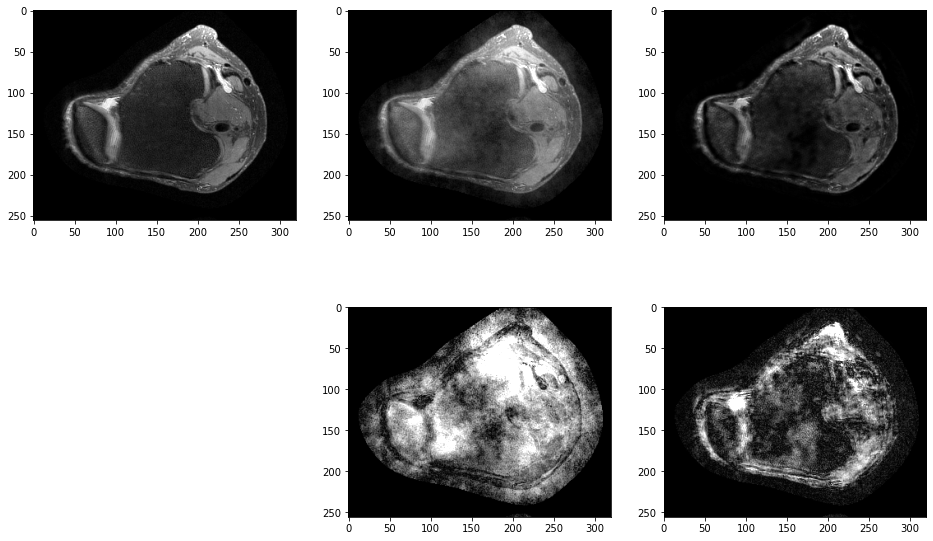

In [9]:
dt_path = root_dir+"/out_dir_r2"
img_gt = np.load(dt_path+"/gt_img_30.npy")
img_inp = np.load(dt_path+"/inp_img_30.npy")
img_out = np.load(dt_path+"/out_img_30.npy")
gt_max = abs(img_gt).max()/1.5
gt_min = abs(img_gt).min()
plt.figure(figsize=(16,10))
plt.subplot(2,3,1)
plt.imshow(abs(img_gt), cmap="gray" , vmin=gt_min, vmax=gt_max)
plt.subplot(2,3,2)
plt.imshow(abs(img_inp), cmap="gray" , vmin=gt_min, vmax=gt_max)
plt.subplot(2,3,3)
plt.imshow(abs(img_out), cmap="gray" , vmin=gt_min, vmax=gt_max)
plt.subplot(2,3,5)
plt.imshow(5*abs((img_gt-img_inp)), cmap="gray" , vmin=gt_min, vmax=gt_max)
plt.subplot(2,3,6)
plt.imshow(5*abs((img_gt-img_out)), cmap="gray" , vmin=gt_min, vmax=gt_max)

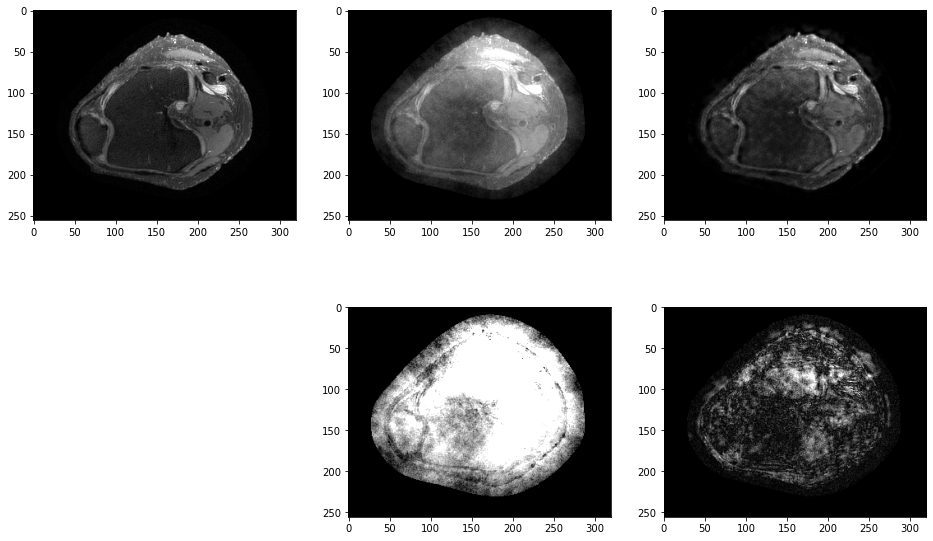

In [10]:
dt_path = root_dir+"/out_dir_r3"
img_gt = np.load(dt_path+"/gt_img_30.npy")
img_inp = np.load(dt_path+"/inp_img_30.npy")
img_out = np.load(dt_path+"/out_img_30.npy")
gt_max = abs(img_gt).max()/1.5
gt_min = abs(img_gt).min()

plt.figure(figsize=(16,10))
plt.subplot(2,3,1)
plt.imshow(abs(img_gt), cmap="gray" , vmin=gt_min, vmax=gt_max)
plt.subplot(2,3,2)
plt.imshow(abs(img_inp), cmap="gray" , vmin=gt_min, vmax=gt_max)
plt.subplot(2,3,3)
plt.imshow(abs(img_out), cmap="gray" , vmin=gt_min, vmax=gt_max)
plt.subplot(2,3,5)
plt.imshow(5*abs((img_gt-img_inp)), cmap="gray" , vmin=gt_min, vmax=gt_max)
plt.subplot(2,3,6)
plt.imshow(5*abs((img_gt-img_out)), cmap="gray" , vmin=gt_min, vmax=gt_max)

<BarContainer object of 2 artists>

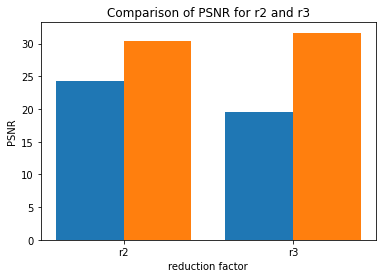

In [13]:
# Display the mean of PSNR value over test data
x = np.arange(2)
y1 = [inp_r2[0], inp_r3[0]]
y2 = [out_r2[0], out_r3[0]]
width = 0.40
  
# plot data in grouped manner of bar type
plt.title("Comparison of PSNR for r2 and r3")
plt.ylabel("PSNR")
plt.xlabel("reduction factor")
plt.xticks(x, ['r2','r3'])
plt.bar(x-0.2, y1, width)
plt.bar(x+0.2, y2, width)

<BarContainer object of 2 artists>

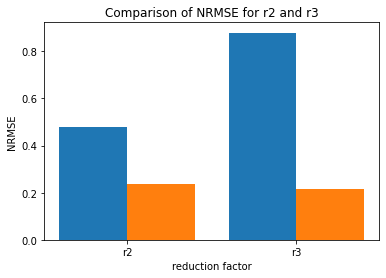

In [14]:
# Display the mean of NRMSE value over test data
x = np.arange(2)
y1 = [inp_r2[1], inp_r3[1]]
y2 = [out_r2[1], out_r3[1]]
width = 0.40
  
# plot data in grouped manner of bar type
plt.title("Comparison of NRMSE for r2 and r3")
plt.ylabel("NRMSE")
plt.xlabel("reduction factor")
plt.xticks(x, ['r2','r3'])
plt.bar(x-0.2, y1, width)
plt.bar(x+0.2, y2, width)

<BarContainer object of 2 artists>

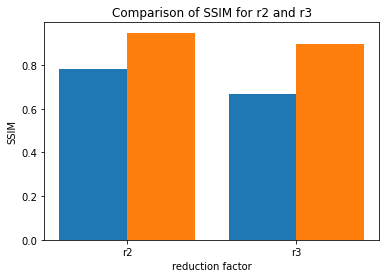

In [15]:
# Display the mean of SSIM value over test data
x = np.arange(2)
y1 = [inp_r2[2], inp_r3[2]]
y2 = [out_r2[2], out_r3[2]]
width = 0.40
  
# plot data in grouped manner of bar type
plt.title("Comparison of SSIM for r2 and r3")
plt.ylabel("SSIM")
plt.xlabel("reduction factor")
plt.xticks(x, ['r2','r3'])
plt.bar(x-0.2, y1, width)
plt.bar(x+0.2, y2, width)

In [25]:
perf_path = root_dir + "/testresult_box.csv" 


In [26]:
df = pd.read_csv(perf_path)
df.head()

,psnr,nrmse,ssim,r,status
0,24.009,0.498,0.8,r2,input
1,30.868,0.226,0.927,r2,output
2,24.393,0.645,0.765,r2,input
3,33.374,0.229,0.911,r2,output
4,24.773,0.433,0.819,r2,input


In [27]:
df['psnr'] = pd.to_numeric(df['psnr'],errors='coerce')
df['nrmse'] = pd.to_numeric(df['nrmse'],errors='coerce')
df['ssim'] = pd.to_numeric(df['ssim'],errors='coerce')


Text(0.5, 0, 'DATA-SIZE')

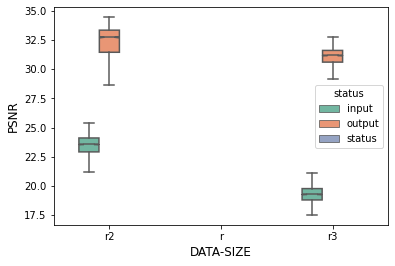

In [22]:
#the box plot using Seaborn library. The y-axis represents the PSNR values, x-axis represent the reduction factor
# the result shows for all images in the test data 
# For example the median psnr value for r2 is 32.6 while for r3 31
sns.boxplot(y='psnr',x='r',hue="status", data=df, width=0.55 ,palette="Set2", showfliers=False,notch=True,
                dodge=True)
plt.ylabel("PSNR", fontsize= 12)
plt.xlabel("DATA-SIZE", fontsize= 12)

Text(0.5, 0, 'DATA-SIZE')

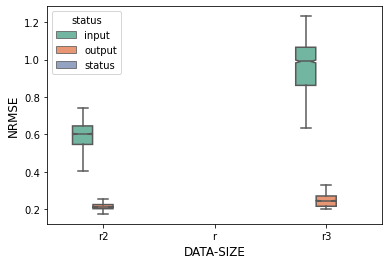

In [23]:
sns.boxplot(y='nrmse',x='r',hue="status", data=df, width=0.55 ,palette="Set2", showfliers=False,notch=True,
                dodge=True)
plt.ylabel("NRMSE", fontsize= 12)
plt.xlabel("DATA-SIZE", fontsize= 12)

Text(0.5, 0, 'DATA-SIZE')

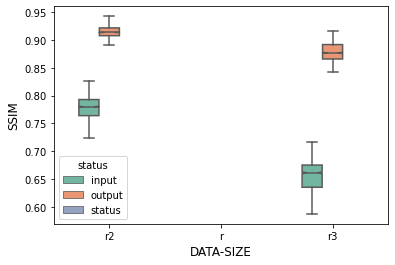

In [24]:
sns.boxplot(y='ssim',x='r',hue="status", data=df, width=0.55 ,palette="Set2", showfliers=False,notch=True,
                dodge=True)
plt.ylabel("SSIM", fontsize= 12)
plt.xlabel("DATA-SIZE", fontsize= 12)